In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:

def transform(src_pts, H):
    src = np.pad(src_pts, ((0, 0), (0, 1)), constant_values=1)
    des = np.dot(H, src.T).T
    des = (des / des[:, 2].reshape(-1, 1))[:, :2]
    return des

src_pts = np.array([[0, 0], [0, 1], [1, 1], [1, 0]], dtype=np.float32)
H = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float32)
des_pts = transform(src_pts, H)
print(des_pts)

[[0. 0.]
 [0. 1.]
 [1. 1.]
 [1. 0.]]


In [ ]:
import os
os.chdir('D:/ES666')

In [3]:
print(os.getcwd())  # This should output: D:\


D:\


In [5]:
gt_images = []
for files in tqdm(natsorted(glob('Images/I1/*'))):
    gt_images.append(cv2.imread(files, 1))

gt_images = np.array(gt_images)

0it [00:00, ?it/s]


In [ ]:
def get_keypoints_discriptors(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    return keypoints1, descriptors1, keypoints2, descriptors2
def find_matches(keypoints1, keypoints2):
    matches = []

    for i in range(len(keypoints1)):
        distances = np.linalg.norm(keypoints2 - keypoints1[i], axis=1)
        m = np.argmin(distances)
        n = np.argsort(distances)[1]
        if distances[m] < 0.75 * distances[n]:
            matches.append([i, m])
    return np.array(matches)

def compute_homography(matches, keypoints_src, keypoints_des):
    A = []

    for i, j in matches:
        x1, y1 = keypoints_src[i].pt
        x2, y2 = keypoints_des[j].pt

        # Populate A matrix for the homogeneous transformation
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])

    # Convert A to numpy array
    A = np.array(A)

    # Solve Ah = 0 using SVD
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)

    # Normalize H to make the bottom-right value 1
    H = H / H[2, 2]
    return H
def RANSAC_homography(matches, keypoints1, keypoints2, p=0.99, threshold=6.0, e=0.6):
    # assert keypoints1.shape[0] == keypoints2.shape[0]
    s = 4
    N = np.ceil(np.log(1 - p) / np.log(1 - (1 - e)**s))

    max_inliers_idx = []

    for _ in range(int(N)):
        idx = np.random.choice(range(len(matches)), size=s, replace=False)
        # print(idx)
        H = compute_homography(matches[idx], keypoints1, keypoints2)
        # print(H)

        inliers_idx = []

        for i,j in matches:
            x1, y1 = keypoints1[i].pt
            x2, y2 = keypoints2[j].pt
            p1 = np.array([x1, y1, 1])
            p2 = np.array([x2, y2, 1])
            p1_transformed = H @ p1
            p1_transformed /= p1_transformed[2]
            d = np.linalg.norm(p2 - p1_transformed)

            if d < threshold:
                inliers_idx.append([i, j])

        if len(inliers_idx) > len(max_inliers_idx):
            # print(len(inliers_idx))
            max_inliers_idx = inliers_idx

    max_inliers_idx = np.array(max_inliers_idx)

    H = compute_homography(max_inliers_idx, keypoints1, keypoints2)
    return H, max_inliers_idx
def draw_matches(img1, img2, keypoints1, keypoints2, matches):
    # Ensure both images are in 3-channel format for color display
    if len(img1.shape) == 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    if len(img2.shape) == 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Create a canvas for displaying the two images side by side
    img3 = np.zeros((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
    img3[:img1.shape[0], :img1.shape[1]] = img1
    img3[:img2.shape[0], img1.shape[1]:] = img2

    # Draw lines between matching keypoints
    for i, j in matches:
        x1, y1 = keypoints1[i].pt
        x2, y2 = keypoints2[j].pt

        # Shift x2 by the width of img1 to account for concatenation
        x2 += img1.shape[1]

        # Draw the match line in green
        cv2.line(img3, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)

    return img3
def is_point_in_quadrilateral(px, py, quadrilateral):
    # Unpack the quadrilateral vertices
    (x1, y1), (x2, y2), (x3, y3), (x4, y4) = quadrilateral

    # Helper function to calculate the cross product
    def cross_product(x1, y1, x2, y2, x3, y3):
        return (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)

    # Calculate the cross products for the edges of the quadrilateral
    cross1 = cross_product(x1, y1, x2, y2, px, py)
    cross2 = cross_product(x2, y2, x3, y3, px, py)
    cross3 = cross_product(x3, y3, x4, y4, px, py)
    cross4 = cross_product(x4, y4, x1, y1, px, py)

    # Check if all cross products have the same sign
    return (cross1 >= 0 and cross2 >= 0 and cross3 >= 0 and cross4 >= 0) or \
           (cross1 <= 0 and cross2 <= 0 and cross3 <= 0 and cross4 <= 0)
def bilinear_interpolate(img, x, y):
    h, w, _ = img.shape
    x0 = int(np.floor(x))
    x1 = int(np.ceil(x))
    y0 = int(np.floor(y))
    y1 = int(np.ceil(y))

    # Clamp coordinates to be within image boundaries
    x0 = max(0, min(x0, w - 1))
    x1 = max(0, min(x1, w - 1))
    y0 = max(0, min(y0, h - 1))
    y1 = max(0, min(y1, h - 1))
    # Get the four surrounding pixel values
    I00 = img[y0, x0, :]
    I01 = img[y0, x1, :]
    I10 = img[y1, x0, :]
    I11 = img[y1, x1, :]

    # Interpolate
    a = (x1 - x) * (y1 - y) * I00 + (x - x0) * (y1 - y) * I01 + (x1 - x) * (y - y0) * I10 + (x - x0) * (y - y0) * I11
    return np.clip(a, 0, 255)
def forward_transformation(img, H):
    h, w = img.shape[:2]

    corner_A = np.array([0, 0, 1])
    corner_B = np.array([w - 1, 0, 1])
    corner_C = np.array([w - 1, h - 1, 1])
    corner_D = np.array([0, h - 1, 1])

    transformed_A = H @ corner_A
    transformed_B = H @ corner_B
    transformed_C = H @ corner_C
    transformed_D = H @ corner_D

    transformed_A /= transformed_A[2]
    transformed_B /= transformed_B[2]
    transformed_C /= transformed_C[2]
    transformed_D /= transformed_D[2]
    transform_corners = np.array([transformed_A[:2], transformed_B[:2], transformed_C[:2], transformed_D[:2]], dtype=np.int32)

    return transform_corners, transformed_A[:2], transformed_B[:2], transformed_C[:2], transformed_D[:2]
def backward_transformation(img, H, offset_mat, canvas, quadrilateral):
    H_inv = np.linalg.inv(H)
    H_inv /= H_inv[2, 2]
    h, w = canvas.shape[:2]

    for y in range(h):
        for x in range(w):
            if is_point_in_quadrilateral(x, y, quadrilateral):

                p = np.array([x, y, 1], dtype=np.float32)
                p = offset_mat @ p
                p /= p[2]
                p_transformed = H_inv @ p
                p_transformed /= p_transformed[2]

                if 0 <= p_transformed[0] < img.shape[1] and 0 <= p_transformed[1] < img.shape[0]:

                    interpolated_color = bilinear_interpolate(img, p_transformed[0], p_transformed[1])
                    interpolated_color = interpolated_color.astype(np.uint8)
                    canvas[y, x, :] = interpolated_color

    return canvas

def get_homography_matrix(src_img, des_img):
    keypoints1, descriptors1, keypoints2, descriptors2 = get_keypoints_discriptors(src_img, des_img)
    matches = find_matches(descriptors1, descriptors2)
    H, inliers = RANSAC_homography(matches, keypoints1, keypoints2)
    return H

def plot_image(img, title, cmap=None):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def transform_corners(img, matrix):
    # Normalize matrix
    matrix = matrix / matrix[2, 2]
    matrix /= np.linalg.norm(matrix)

    h, w = img.shape[:2]
    # Define corners of the image
    corners = np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float64).reshape(-1, 1, 2)

    # Apply perspective transform to the corners
    transformed_corners = cv2.perspectiveTransform(corners, matrix)

    # Calculate minimum and maximum x and y coordinates
    x_min, y_min = np.int32(transformed_corners.min(axis=0).ravel())
    x_max, y_max = np.int32(transformed_corners.max(axis=0).ravel())

    return x_min, y_min, x_max, y_max, transformed_corners

def single_weights_array(size: int) -> np.ndarray:
    if size % 2 == 1:
        return np.concatenate(
            [np.linspace(0, 1, (size + 1) // 2), np.linspace(1, 0, (size + 1) // 2)[1:]]
        )
    else:
        return np.concatenate([np.linspace(0, 1, size // 2), np.linspace(1, 0, size // 2)])

def single_weights_matrix(shape: tuple[int]) -> np.ndarray:
    return (
        single_weights_array(shape[0])[:, np.newaxis]
        @ single_weights_array(shape[1])[:, np.newaxis].T
    )
    


In [4]:
def image_stitching_backward(src_img, des_img):
    weight_1 = single_weights_matrix(src_img.shape[:2])
    weight_2 = single_weights_matrix(des_img.shape[:2])
    # Step 1: Get keypoints and descriptors
    keypoints_src, descriptors_src, keypoints_des, descriptors_des = get_keypoints_discriptors(src_img, des_img)

    # Step 2: Find matches and compute the homography matrix with RANSAC
    matches = find_matches(descriptors_src, descriptors_des)
    H, inliers = RANSAC_homography(matches, keypoints_src, keypoints_des)
    x_min, y_min, x_max, y_max, transformed_corners = transform_corners(src_img, H)

    # Offset translation matrix to handle negative minimums
    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float64)

    canvas_width = max(des_img.shape[1] - int(x_min), int(x_max) - int(x_min))
    canvas_height = max(des_img.shape[0] - int(y_min), int(y_max) - int(y_min))

    image3_warped = cv2.warpPerspective(des_img, translation_mat, (canvas_width, canvas_height))
    weight_2_warped = cv2.warpPerspective(weight_2, translation_mat, (canvas_width, canvas_height))
    # Step 4: Warp the source image to align with the destination image using offset

    src_img_warped = cv2.warpPerspective(src_img,  translation_mat @ H, (canvas_width, canvas_height))

    weight1_warped = cv2.warpPerspective(weight_1, translation_mat @ H, (canvas_width, canvas_height))
    weight_1_warped = np.repeat(weight1_warped[:, :, np.newaxis], 3, axis=2)
    weight_2_warped = np.repeat(weight_2_warped[:, :, np.newaxis], 3, axis=2)
    # Step 5: Blend the warped source image with the destination image

    total_weight = (weight_1_warped + weight_2_warped) / (weight_1_warped + weight_2_warped).max()

    weight_1_normalized = np.divide(weight_1_warped, total_weight, where=total_weight!=0)
    weight_2_normalized = np.divide(weight_2_warped, total_weight, where=total_weight!=0)

    image_final = (weight_1_normalized * src_img_warped + weight_2_normalized * image3_warped).astype(np.uint8)
    return image_final, translation_mat, total_weight, weight_1_warped,weight_2_warped, src_img_warped, image3_warped


def blended_image_123(gt_images):
    image_12_warped, shift_12, total_weight_12, weight_1_warped, weight_2_warped, image_1_warped, image_2_warped  = image_stitching_backward(gt_images[0], gt_images[1])
    H = get_homography_matrix(gt_images[1], gt_images[2])
    h,w = image_12_warped.shape[:2]

    corners = np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float64).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners, H @ np.linalg.inv(shift_12))

    x_min, y_min = np.int32(transformed_corners.min(axis=0).ravel())
    x_max, y_max = np.int32(transformed_corners.max(axis=0).ravel())

    image3 = gt_images[2]
    shift_matrix12_3 = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float64)
    canvas_width = image3.shape[1] - int(x_min)
    canvas_height = max(image3.shape[0] - int(y_min), int(y_max) - int(y_min))

    img3_warped = cv2.warpPerspective(image3, shift_matrix12_3, (canvas_width, canvas_height))
    img_12_warped = cv2.warpPerspective(image_12_warped, shift_matrix12_3 @ H @ np.linalg.inv(shift_12), (canvas_width, canvas_height))

    weight3 = single_weights_matrix(image3.shape[:2])

    weight3_warped = cv2.warpPerspective(weight3, shift_matrix12_3 , (canvas_width, canvas_height))
    total_weight12_warped = cv2.warpPerspective(total_weight_12, shift_matrix12_3 @ H @ np.linalg.inv(shift_12), (canvas_width, canvas_height))

    weight3_warped = np.repeat(weight3_warped[:, :, np.newaxis], 3, axis=2)


    total_weight12_3 = (weight3_warped + total_weight12_warped) / (weight3_warped + total_weight12_warped).max()

    weight12_normalized = np.divide(total_weight12_warped,total_weight12_3, where=total_weight12_3!=0)
    weight3_normalized = np.divide(weight3_warped, total_weight12_3, where=total_weight12_3!=0)
    blended_img_warped_123 = (weight12_normalized * img_12_warped + weight3_normalized * img3_warped).astype(np.uint8)
    return blended_img_warped_123, shift_matrix12_3, total_weight12_3, weight3_warped, total_weight12_warped, img_12_warped, img3_warped
    

In [5]:
def forward_img_stitching(src_img,des_img):
    H = get_homography_matrix(src_img, des_img)
    x_min, y_min, x_max, y_max, transformed_corners = transform_corners(src_img, H)
    canvas_width = x_max
    canvas_height = y_max - y_min
    
    src_img_warped = cv2.warpPerspective(src_img, H, (canvas_width, canvas_height))
    des_img_warped = cv2.warpPerspective(des_img, np.eye(3), (canvas_width, canvas_height))
    
    weight_src = single_weights_matrix(src_img.shape[:2])
    weight_des = single_weights_matrix(des_img.shape[:2])
    weight_src_warped = cv2.warpPerspective(weight_src, H, (canvas_width, canvas_height))
    weight_des_warped = cv2.warpPerspective(weight_des, np.eye(3), (canvas_width, canvas_height))
    weight_src_warped = np.repeat(weight_src_warped[:, :, np.newaxis], 3, axis=2)
    weight_des_warped = np.repeat(weight_des_warped[:, :, np.newaxis], 3, axis=2)
    total_weight = (weight_src_warped + weight_des_warped) / (weight_src_warped + weight_des_warped).max()

    weight_src_normalized = np.divide(weight_src_warped, total_weight, where=total_weight!=0)
    weight_des_normalized = np.divide(weight_des_warped, total_weight, where=total_weight!=0)
    
    img_blended = (weight_src_normalized * src_img_warped + weight_des_normalized * des_img_warped).astype(np.uint8)
    
    return img_blended, total_weight, weight_src_warped, weight_des_warped, src_img_warped, des_img_warped

def blended_img_456(gt_images):
    img_56_warped,total_weight_56, weight_5_warped, weight_6_warped, img_5_warped, img_6_warped = forward_img_stitching(gt_images[5], gt_images[4])
    H = get_homography_matrix(gt_images[4], gt_images[3])

    x_min, y_min, x_max, y_max, transformed_corners = transform_corners(img_56_warped, H)
    canvas_width = x_max
    canvas_height = y_max - y_min

    warped_img_56 = cv2.warpPerspective(img_56_warped, H, (canvas_width, canvas_height))
    warped_img_4 = cv2.warpPerspective(gt_images[3], np.eye(3), (canvas_width, canvas_height))
    
    weight_56 = total_weight_56
    weight_4 = single_weights_matrix(gt_images[3].shape[:2])


    weight_4_warped = cv2.warpPerspective(weight_4, np.eye(3), (canvas_width, canvas_height))
    weight_56_warped = cv2.warpPerspective(weight_56, H, (canvas_width, canvas_height))
    weight_4_warped = np.repeat(weight_4_warped[:, :, np.newaxis], 3, axis=2)

    total_weight = (weight_4_warped + weight_56_warped) / (weight_4_warped + weight_56_warped).max()

    weight_4_normalized = np.divide(weight_4_warped, total_weight, where=total_weight!=0)
    weight_56_normalized = np.divide(weight_56_warped, total_weight, where=total_weight!=0)

    img456 = (weight_4_normalized * warped_img_4 + weight_56_normalized * warped_img_56).astype(np.uint8)
    
    return img456, total_weight, weight_4_warped, weight_56_warped, warped_img_4, warped_img_56

In [6]:
def image_stitching(gt_images):
    if len(gt_images) == 5:
        img123, shift_matrix12_3, total_weight12_3, weight3_warped, total_weight12_warped, img_12_warped, img3_warped = blended_image_123(gt_images)
        img45, total_weight45, weight4_warped, weight5_warped, img_4_warped, img_5_warped = forward_img_stitching(gt_images[4], gt_images[3])
        H = get_homography_matrix(gt_images[3], gt_images[2])
        x_min, y_min, x_max, y_max, transformed_corners = transform_corners(img45, H)
        canvas_width = x_max
        canvas_height = y_max - y_min
        img45_warped = cv2.warpPerspective(img45, H @ shift_matrix12_3, (canvas_width, canvas_height))
        img123_warped = cv2.warpPerspective(img123, np.eye(3), (canvas_width, canvas_height))
        weight45 = total_weight45
        weight123 = total_weight12_3
        weight45_warped = cv2.warpPerspective(weight45, H @ shift_matrix12_3, (canvas_width, canvas_height))
        weight123_warped = cv2.warpPerspective(weight123, np.eye(3), (canvas_width, canvas_height))
        
        total_weight = (weight45_warped + weight123_warped) / (weight45_warped + weight123_warped).max()

        weight_123_normalized = np.divide(weight123_warped, total_weight, where=total_weight!=0)
        weight_45_normalized = np.divide(weight45_warped, total_weight, where=total_weight!=0)
        
        img_final = (weight_123_normalized * img123_warped + weight_45_normalized * img45_warped).astype(np.uint8)
        return img_final, total_weight, weight45_warped, weight123_warped, img45_warped, img123_warped
    elif len(gt_images) == 6:
        img123, shift_matrix12_3, total_weight12_3, weight3_warped, total_weight12_warped, img_12_warped, img3_warped = blended_image_123(gt_images)
        img456, total_weight_456, weight_4_warped, weight_56_warped, warped_img_4, warped_img_56 = blended_img_456(gt_images)
        H = get_homography_matrix(gt_images[3], gt_images[2])
        x_min, y_min, x_max, y_max, transformed_corners = transform_corners(img456, H)
        canvas_width = x_max
        canvas_height = y_max - y_min
        img456_warped = cv2.warpPerspective(img456, H @ shift_matrix12_3, (canvas_width, canvas_height))
        img123_warped = cv2.warpPerspective(img123, np.eye(3), (canvas_width, canvas_height))
        weight456 = total_weight_456
        weight123 = total_weight12_3
        weight456_warped = cv2.warpPerspective(weight456, H @ shift_matrix12_3, (canvas_width, canvas_height))
        weight123_warped = cv2.warpPerspective(weight123, np.eye(3), (canvas_width, canvas_height))
        
        total_weight = (weight456_warped + weight123_warped) / (weight456_warped + weight123_warped).max()
        
        weight_123_normalized = np.divide(weight123_warped, total_weight, where=total_weight!=0)
        weight_456_normalized = np.divide(weight456_warped, total_weight, where=total_weight!=0)
        
        img_final = (weight_123_normalized * img123_warped + weight_456_normalized * img456_warped).astype(np.uint8)
        return img_final, total_weight, weight456_warped, weight123_warped, img456_warped, img123_warped
    
        
        

# Stitching Image 1 and Image 2

In [7]:
blended_image_12, shift_matrix12, total_weight12, weight_1_warped, weight_2_warped, image_1_warped, image_2_warped = image_stitching_backward(gt_images[0], gt_images[1])

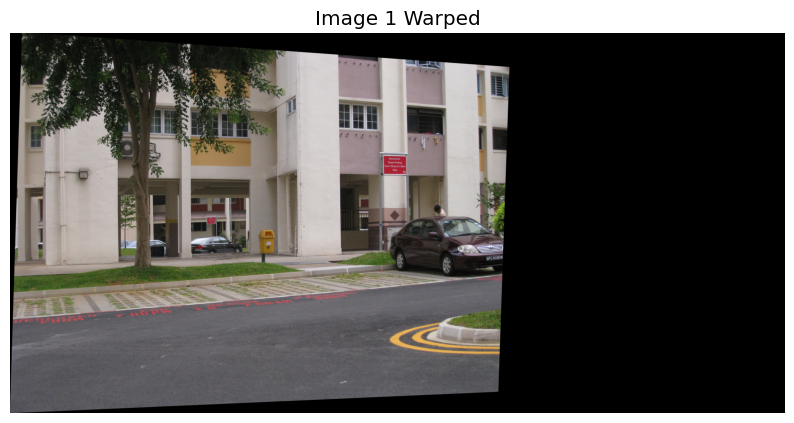

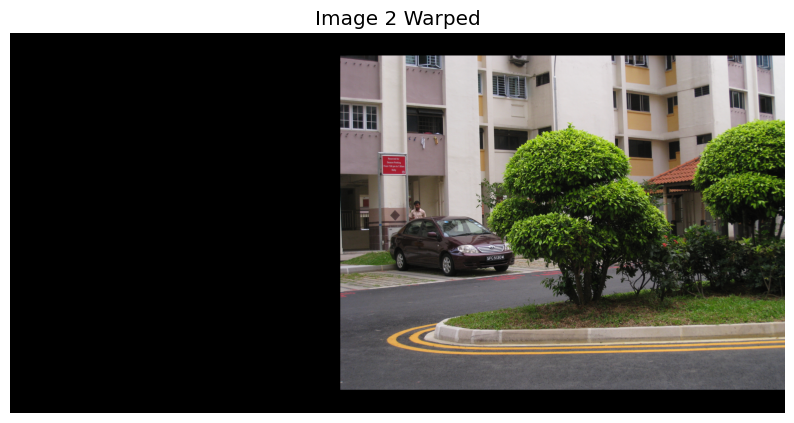

In [8]:
plot_image(image_1_warped, 'Image 1 Warped')
plot_image(image_2_warped, 'Image 2 Warped')

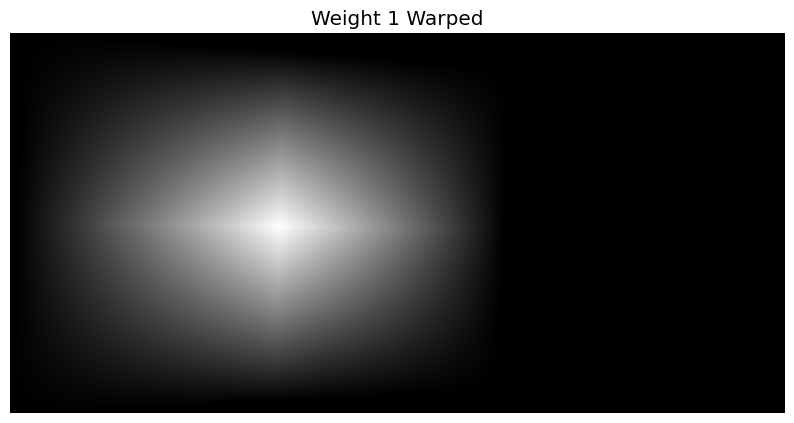

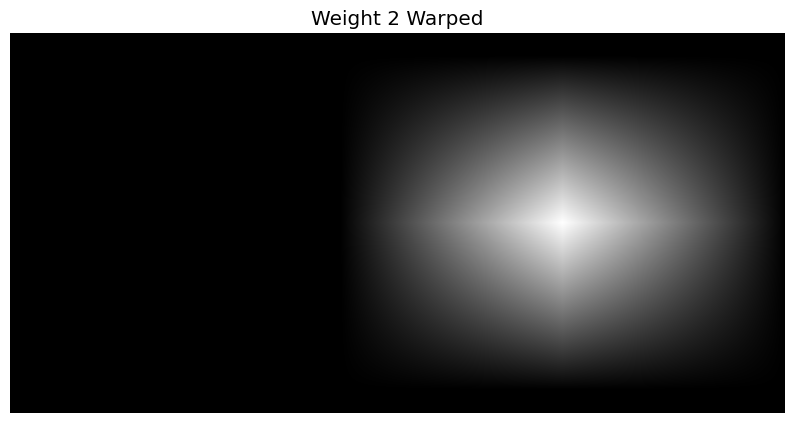

In [9]:
plot_image(weight_1_warped, 'Weight 1 Warped', cmap='gray')
plot_image(weight_2_warped, 'Weight 2 Warped', cmap='gray')

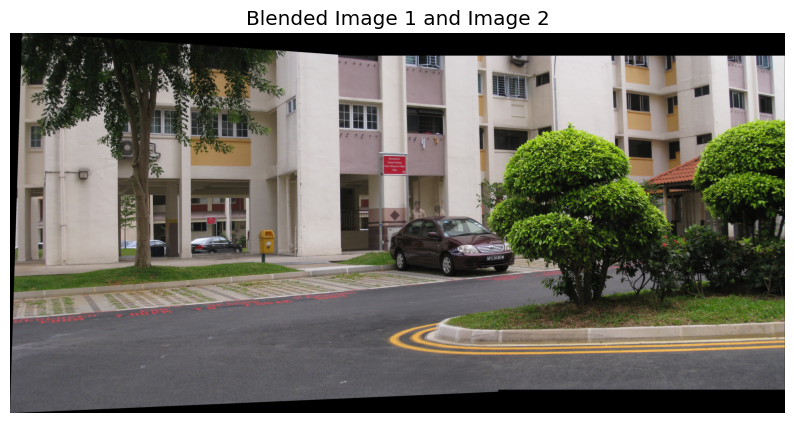

In [10]:
plot_image(blended_image_12, 'Blended Image 1 and Image 2')

# Stitching of Image 1,2 with Image 3

In [11]:
H = get_homography_matrix(gt_images[1], gt_images[2])

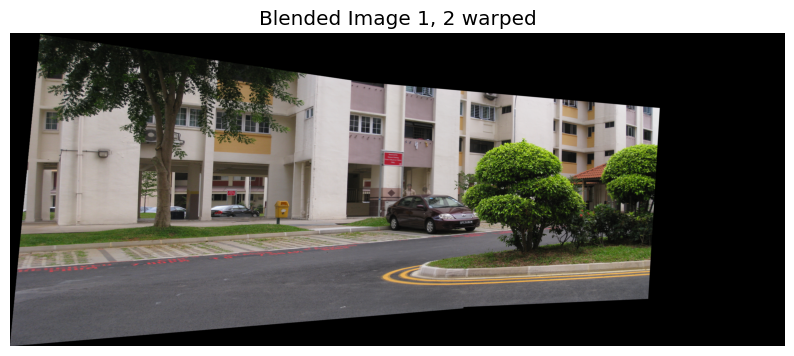

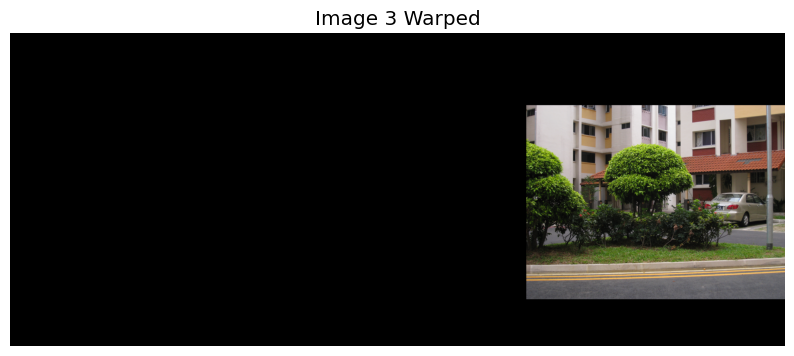

In [12]:
h,w = blended_image_12.shape[:2]

corners = np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float64).reshape(-1, 1, 2)
transformed_corners = cv2.perspectiveTransform(corners, H @ np.linalg.inv(shift_matrix12))

x_min, y_min = np.int32(transformed_corners.min(axis=0).ravel())
x_max, y_max = np.int32(transformed_corners.max(axis=0).ravel())

image3 = gt_images[2]
shift_matrix12_3 = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float64)
canvas_width = image3.shape[1] - int(x_min)
canvas_height = max(image3.shape[0] - int(y_min), int(y_max) - int(y_min))

image3_warped = cv2.warpPerspective(image3, shift_matrix12_3, (canvas_width, canvas_height))
blended_img_12_warped = cv2.warpPerspective(blended_image_12, shift_matrix12_3 @ H @ np.linalg.inv(shift_matrix12), (canvas_width, canvas_height))

plot_image(blended_img_12_warped, 'Blended Image 1, 2 warped')
plot_image(image3_warped, 'Image 3 Warped')

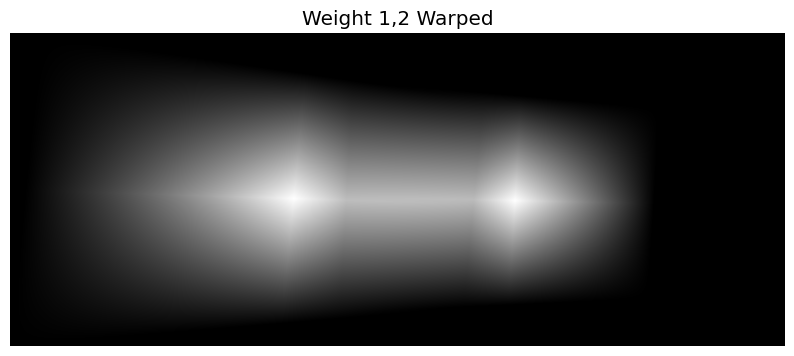

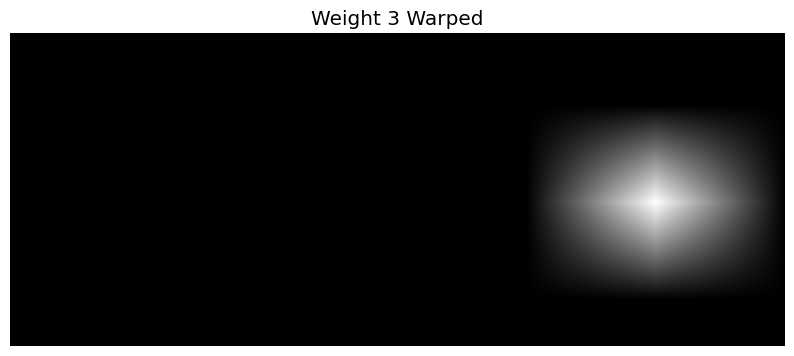

In [13]:
weight3 = single_weights_matrix(image3.shape[:2])

weight3_warped = cv2.warpPerspective(weight3, shift_matrix12_3 , (canvas_width, canvas_height))
total_weight12_warped = cv2.warpPerspective(total_weight12, shift_matrix12_3 @ H @ np.linalg.inv(shift_matrix12), (canvas_width, canvas_height))

weight3_warped = np.repeat(weight3_warped[:, :, np.newaxis], 3, axis=2)


total_weight12_3 = (weight3_warped + total_weight12_warped) / (weight3_warped + total_weight12_warped).max()

weight12_normalized = np.divide(total_weight12_warped,total_weight12_3, where=total_weight12_3!=0)
weight3_normalized = np.divide(weight3_warped, total_weight12_3, where=total_weight12_3!=0)

plot_image(total_weight12_warped, 'Weight 1,2 Warped', cmap='gray')
plot_image(weight3_warped, 'Weight 3 Warped', cmap='gray')

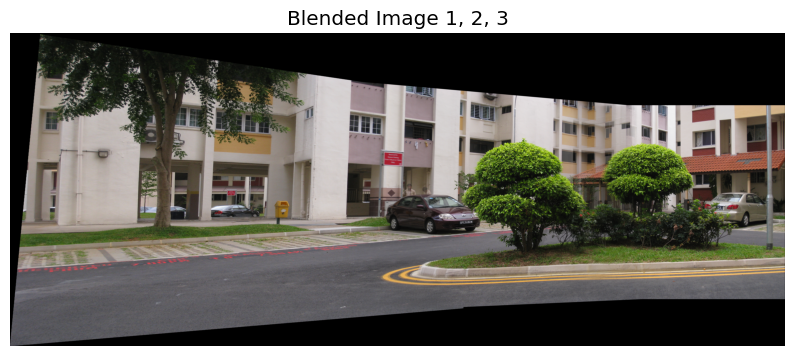

In [14]:
blended_img_warped_123 = (weight12_normalized * blended_img_12_warped + weight3_normalized * image3_warped).astype(np.uint8)
img123 = blended_img_warped_123

plot_image(img123, 'Blended Image 1, 2, 3')

In [15]:
print(shift_matrix12_3)

[[1.000e+00 0.000e+00 6.514e+03]
 [0.000e+00 1.000e+00 9.100e+02]
 [0.000e+00 0.000e+00 1.000e+00]]


In [16]:
cv2.imwrite('img123.png',img123)

True

In [17]:
cv2.imwrite('weight123.png', total_weight12_3)

True

In [18]:
import gc
del weight3_warped
del total_weight12_warped
del weight3
del weight3_normalized
del weight12_normalized
del blended_img_12_warped
del image3_warped
del weight_1_warped
del weight_2_warped
del image_1_warped
del image_2_warped

# Stiching Of Image 4,5 and 6

## Stitching Of Image 6 with Image 5

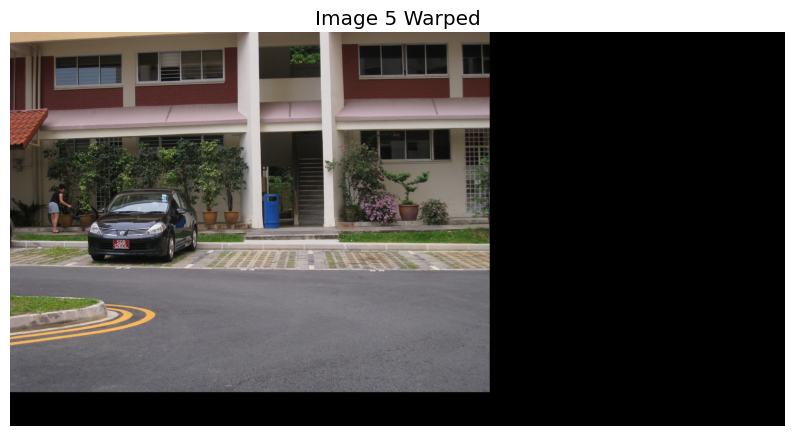

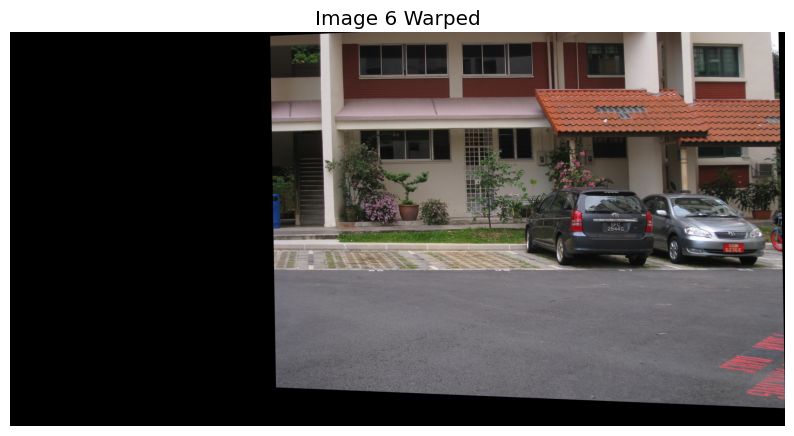

In [19]:
H = get_homography_matrix(gt_images[5], gt_images[4])
x_min, y_min, x_max, y_max, transformed_corners = transform_corners(gt_images[4], H)

canvas_width = x_max
canvas_height = y_max - y_min

img_6_warped = cv2.warpPerspective(gt_images[5], H, (canvas_width, canvas_height))
img_5_warped = cv2.warpPerspective(gt_images[4], np.eye(3), (canvas_width, canvas_height))

plot_image(img_5_warped, 'Image 5 Warped')
plot_image(img_6_warped, 'Image 6 Warped')

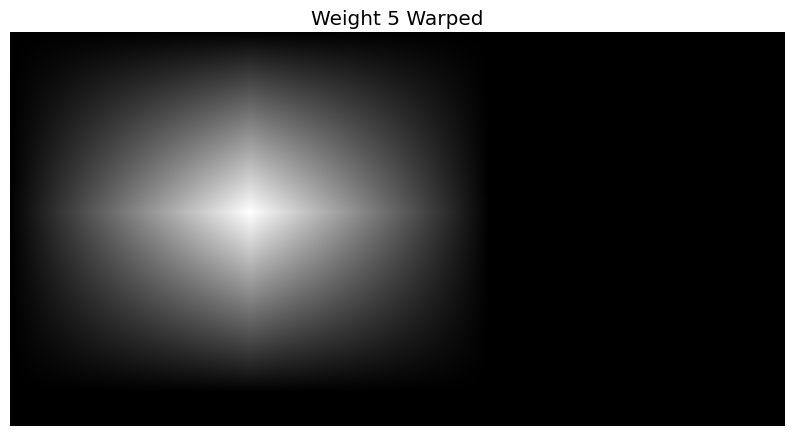

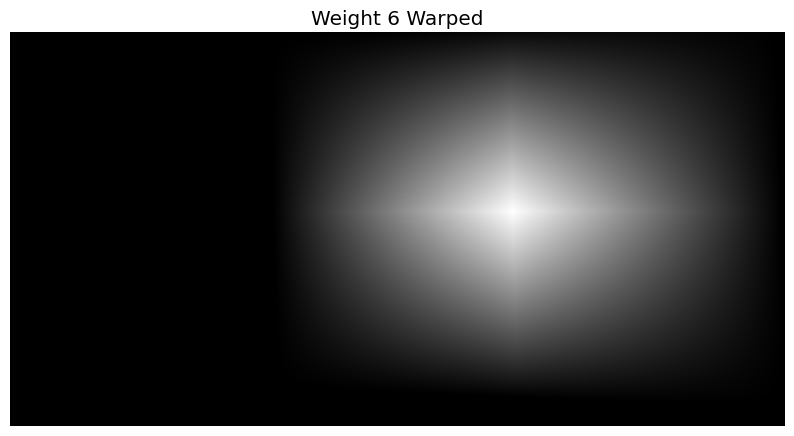

In [20]:
weight_5 = single_weights_matrix(gt_images[4].shape[:2])
weight_6 = single_weights_matrix(gt_images[5].shape[:2])
weight_5_warped = cv2.warpPerspective(weight_5, np.eye(3), (canvas_width, canvas_height))
weight_6_warped = cv2.warpPerspective(weight_6, H, (canvas_width, canvas_height))
weight_5_warped = np.repeat(weight_5_warped[:, :, np.newaxis], 3, axis=2)
weight_6_warped = np.repeat(weight_6_warped[:, :, np.newaxis], 3, axis=2)
total_weight_56 = (weight_5_warped + weight_6_warped) / (weight_5_warped + weight_6_warped).max()

weight_5_normalized = np.divide(weight_5_warped, total_weight_56, where=total_weight_56!=0)
weight_6_normalized = np.divide(weight_6_warped, total_weight_56, where=total_weight_56!=0)

plot_image(weight_5_warped, 'Weight 5 Warped', cmap='gray')
plot_image(weight_6_warped, 'Weight 6 Warped', cmap='gray')

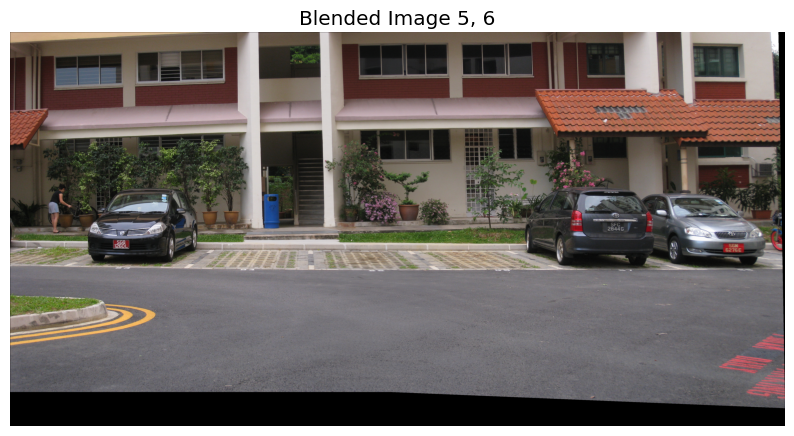

In [21]:
img_56 = (weight_5_normalized * img_5_warped+ weight_6_normalized * img_6_warped).astype(np.uint8)
plot_image(img_56, 'Blended Image 5, 6')

## Stitching Of Image 4 with Image 5,6

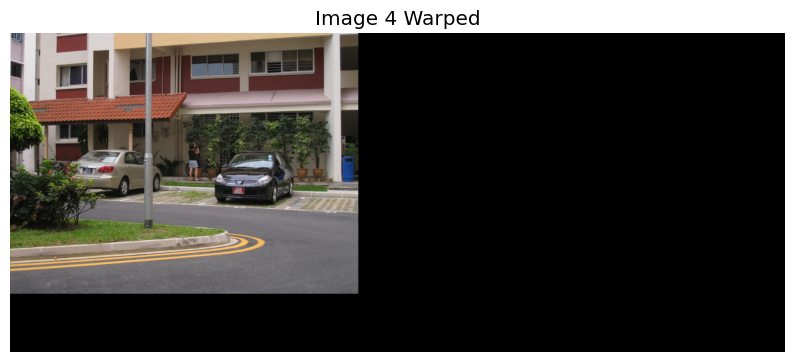

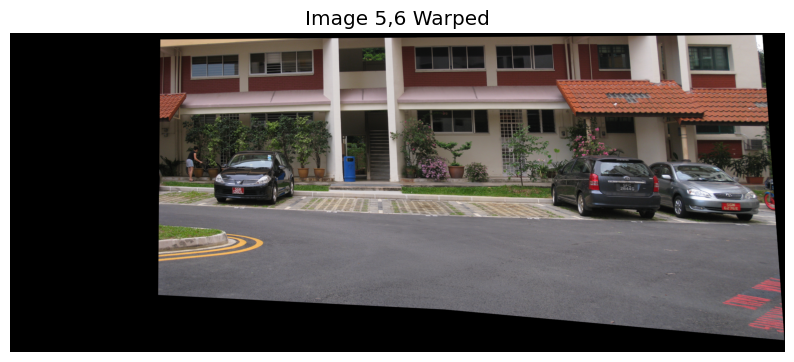

In [22]:
H = get_homography_matrix(gt_images[4], gt_images[3])

x_min, y_min, x_max, y_max, transformed_corners = transform_corners(img_56, H)
canvas_width = x_max
canvas_height = y_max - y_min

warped_img_56 = cv2.warpPerspective(img_56, H, (canvas_width, canvas_height))
warped_img_4 = cv2.warpPerspective(gt_images[3], np.eye(3), (canvas_width, canvas_height))


plot_image(warped_img_4, 'Image 4 Warped')
plot_image(warped_img_56, 'Image 5,6 Warped')

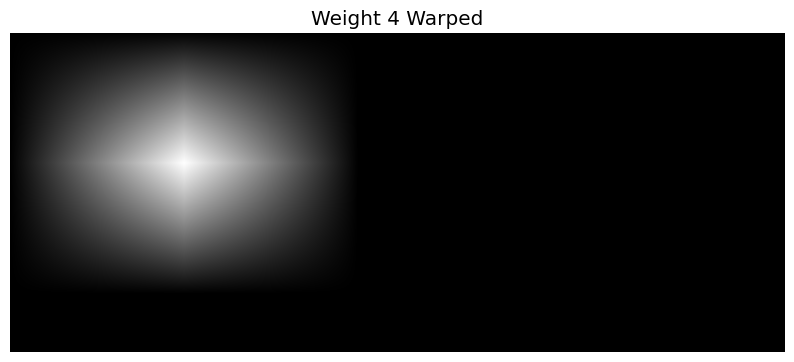

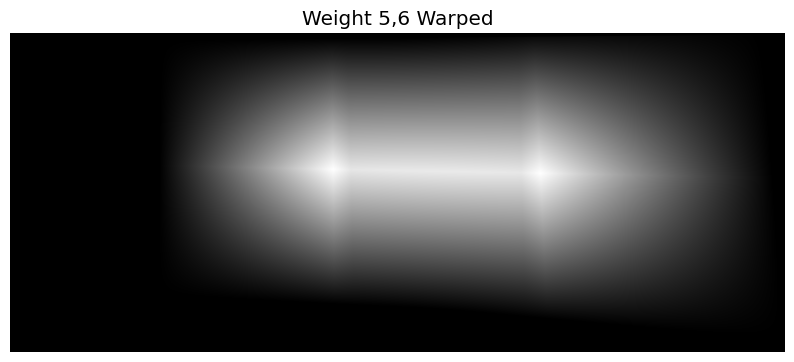

In [23]:
weight_56 = total_weight_56
weight_4 = single_weights_matrix(gt_images[3].shape[:2])


weight_4_warped = cv2.warpPerspective(weight_4, np.eye(3), (canvas_width, canvas_height))
weight_56_warped = cv2.warpPerspective(weight_56, H, (canvas_width, canvas_height))
weight_4_warped = np.repeat(weight_4_warped[:, :, np.newaxis], 3, axis=2)

total_weight = (weight_4_warped + weight_56_warped) / (weight_4_warped + weight_56_warped).max()

weight_4_normalized = np.divide(weight_4_warped, total_weight, where=total_weight!=0)
weight_56_normalized = np.divide(weight_56_warped, total_weight, where=total_weight!=0)


plot_image(weight_4_warped, 'Weight 4 Warped', cmap='gray')
plot_image(weight_56_warped, 'Weight 5,6 Warped', cmap='gray')



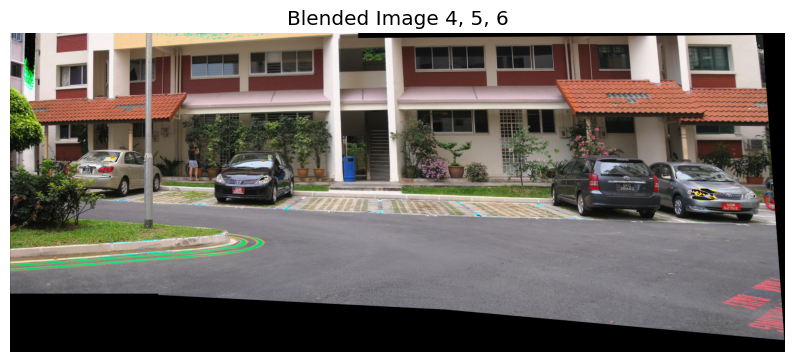

In [24]:
img456 = (weight_4_normalized * warped_img_4 + weight_56_normalized * warped_img_56).astype(np.uint8)
plot_image(img456, 'Blended Image 4, 5, 6')

In [25]:
cv2.imwrite('img456.png', img456)

True

In [26]:
del img_5_warped
del img_6_warped
del weight_5_warped
del weight_6_warped
del weight_6
del weight_4
del weight_5
del weight_4_warped

del weight_4_normalized
del weight_56_normalized
del img_5_warped
del img_6_warped
del img_56

NameError: name 'img_5_warped' is not defined

In [ ]:
img123 = cv2.imread('img123.png')
img456 = cv2.imread('img456.png')

# Stitching Of Image 1,2,3 with Image 4,5,6

In [42]:
H32 = get_homography_matrix(gt_images[3], gt_images[2])

x_min, y_min, x_max, y_max, transformed_corners = transform_corners(img456, H32 @ shift_matrix12_3)
canvas_width = x_max
canvas_height = y_max - y_min

warped_img_456 = cv2.warpPerspective(img456, shift_matrix12_3 @ H32, (canvas_width, canvas_height))
warped_img_123 = cv2.warpPerspective(img123, np.eye(3), (canvas_width, canvas_height))


plot_image(warped_img_123, 'Image 1,2,3 Warped')
plot_image(warped_img_456, 'Image 4,5,6 Warped')

NameError: name 'img456' is not defined

In [29]:
del img456
del img123

In [38]:
del weight_123_warped
del weight_456_warped

In [41]:
# weight_123 = total_weight12_3
# weight_456 = total_weight

weight_123_warped = cv2.warpPerspective(total_weight12_3, np.eye(3), (canvas_width, canvas_height))
weight_456_warped = cv2.warpPerspective(total_weight, H32 @ shift_matrix12_3, (canvas_width, canvas_height))


total_weight = (weight_123_warped + weight_456_warped) / (weight_123_warped + weight_456_warped).max()

weight_123_normalized = np.divide(weight_123_warped, total_weight, where=total_weight!=0)
weight_456_normalized = np.divide(weight_456_warped, total_weight, where=total_weight!=0)

plot_image(weight_123_warped, 'Weight 1,2,3 Warped', cmap='gray')
plot_image(weight_456_warped, 'Weight 4,5,6 Warped', cmap='gray')

MemoryError: Unable to allocate 1.58 GiB for an array with shape (3749, 18839, 3) and data type float64

In [ ]:
final_img = (weight_123_normalized * warped_img_123 + weight_456_normalized * warped_img_456).astype(np.uint8)

plot_image(final_img, 'Final Image')

In [39]:
import numpy as np
import cv2

# Step 1: Define dimensions based on canvas dimensions calculated earlier
canvas_height, canvas_width = int(canvas_height), int(canvas_width)  # Ensure they are integers

# Save `weight_123_warped` and `weight_456_warped` to `D:` using memory-mapped files
weight_123_warped_mmap = np.memmap('D:/weight_123_warped.dat', dtype='float64', mode='w+', shape=(canvas_height, canvas_width, 3))
weight_456_warped_mmap = np.memmap('D:/weight_456_warped.dat', dtype='float64', mode='w+', shape=(canvas_height, canvas_width, 3))

# Write warped weights to memory-mapped arrays
weight_123_warped_mmap[:, :, :] = cv2.warpPerspective(total_weight12_3, np.eye(3), (canvas_width, canvas_height))
weight_456_warped_mmap[:, :, :] = cv2.warpPerspective(total_weight, H32 @ shift_matrix12_3, (canvas_width, canvas_height))

# Step 2: Calculate total_weight and normalize weights
total_weight_mmap = np.memmap('D:/total_weight.dat', dtype='float64', mode='w+', shape=(canvas_height, canvas_width, 3))
total_weight_mmap[:, :, :] = (weight_123_warped_mmap + weight_456_warped_mmap) / (weight_123_warped_mmap + weight_456_warped_mmap).max()

weight_123_normalized_mmap = np.memmap('D:/weight_123_normalized.dat', dtype='float64', mode='w+', shape=(canvas_height, canvas_width, 3))
weight_456_normalized_mmap = np.memmap('D:/weight_456_normalized.dat', dtype='float64', mode='w+', shape=(canvas_height, canvas_width, 3))

# Avoid division by zero
weight_123_normalized_mmap[:, :, :] = np.divide(weight_123_warped_mmap, total_weight_mmap, where=total_weight_mmap != 0)
weight_456_normalized_mmap[:, :, :] = np.divide(weight_456_warped_mmap, total_weight_mmap, where=total_weight_mmap != 0)

# Step 3: Flush data to ensure all changes are saved to disk
weight_123_warped_mmap.flush()
weight_456_warped_mmap.flush()
total_weight_mmap.flush()
weight_123_normalized_mmap.flush()
weight_456_normalized_mmap.flush()


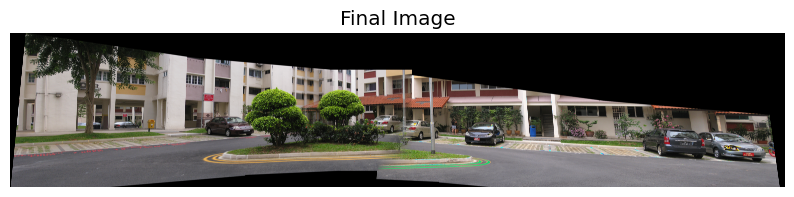

In [40]:
# Reload the saved memory-mapped files
weight_123_normalized = np.memmap('D:/weight_123_normalized.dat', dtype='float64', mode='r', shape=(canvas_height, canvas_width, 3))
weight_456_normalized = np.memmap('D:/weight_456_normalized.dat', dtype='float64', mode='r', shape=(canvas_height, canvas_width, 3))

# Perform the final weighted blending operation
final_img = (weight_123_normalized * warped_img_123 + weight_456_normalized * warped_img_456).astype(np.uint8)

# Display final image
plot_image(final_img, 'Final Image')
